In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, Subset
from torch.utils.data import DataLoader

In [25]:
## Loading in the data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Size of batch
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3854612..1.4739859].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09106481..1.5632443].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44182873..1.3310947].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28040016..1.198136].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44182873..1.4379873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38359928..1.378725].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.240

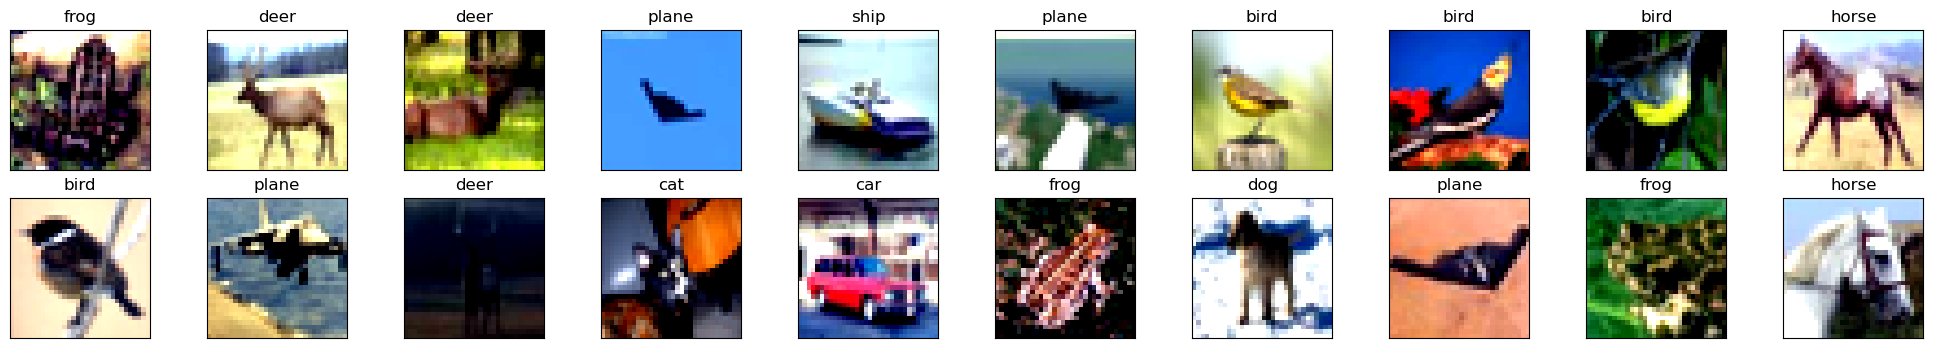

In [ ]:
## Taking a look at the data

# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5  # assuming normalization was applied earlier
    # Convert from tensor image (C x H x W) to (H x W x C)
    plt.imshow(np.transpose(img, (1, 2, 0)))

# Get one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Fetch the next batch of images and labels

# Convert images to numpy for display (if they are in torch.Tensor format)
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

plt.show()
    

In [ ]:
## Training and Test data

total_samples = 40000

# Split the dataset into training and validation sets
# Total desired dataset size: 20,000 samples (15,000 training, 5,000 validation)
num_total_samples = 30000
num_train_samples = 20000
num_val_samples = 10000

# Get the indices of the "frog" class (class 6)
frog_indices = [i for i, label in enumerate(trainset.targets) if label == 6]

# Get the indices of other classes
other_indices = [i for i, label in enumerate(trainset.targets) if label != 6]

# Ensure 50% of the training data consists of "frog" images (7,500 frog images)
num_frog_train = num_train_samples // 2
num_frog_val = num_val_samples // 2  

In [ ]:
## Select "frog" images for training and validation

train_frog_indices = frog_indices[:num_frog_train]
val_frog_indices = frog_indices[num_frog_train:num_frog_train + num_frog_val]

# Randomly select the rest of the images (not frog) for the remaining training and validation data
remaining_train_samples = num_train_samples - num_frog_train
remaining_val_samples = num_val_samples - num_frog_val

In [ ]:
## Fill the rest of the training data with the other categories

# Randomly shuffle the other class indices
np.random.shuffle(other_indices)

# Select the remaining training and validation indices
train_other_indices = other_indices[:remaining_train_samples]
val_other_indices = other_indices[remaining_train_samples:remaining_train_samples + remaining_val_samples]

In [ ]:
## Combine the "frog" and "other" indices for training and validation sets

train_indices = train_frog_indices + train_other_indices
val_indices = val_frog_indices + val_other_indices

# Create the subsets for training and validation
train_subset = Subset(trainset, train_indices)
val_subset = Subset(trainset, val_indices)

In [ ]:
# Create DataLoader for training and validation subsets
batch_size = 64
trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check the sizes of the datasets
print(f'Training set size: {len(trainloader.dataset)}')
print(f'Validation set size: {len(valloader.dataset)}')


Training set size: 15000
Validation set size: 5000


In [28]:
# Donwsampling av datasettet for å få modellen til å lære kategorien bedre

In [ ]:
class FrogClassifier(nn.Module):
    def __init__(self):
        super(FrogClassifier, self).__init__()
        # First Convolutional Layer (Input: 3 channels, Output: 6, Kernel: 5x5)
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  
        # Second Convolutional Layer (Input: 6 channels, Output: 16, Kernel: 5x5)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  
        
        # Dropout layers
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 128)  # Adjusted input size
        self.fc2 = nn.Linear(128, 10)  # Output layer (10 classes)

    def forward(self, data):
        # Convolutional Layer 1 + ReLU + Pooling
        data = F.relu(self.conv_layer1(data))
        data = F.max_pool2d(data, 2)  

        # Convolutional Layer 2 + ReLU + Pooling
        data = F.relu(self.conv_layer2(data))
        data = F.max_pool2d(data, 2)  

        # Apply dropout
        data = self.dropout1(data)

        # Flatten tensor for fully connected layers
        data = torch.flatten(data, 1)

        # Fully Connected Layer 1 + ReLU + Dropout
        data = F.relu(self.fc1(data))
        data = self.dropout2(data)

        # Output Layer
        data = self.fc2(data)

        return F.log_softmax(data, dim=1)

# Instantiate the model
model = FrogClassifier()

# Function to initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

model.apply(init_weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU

print(model)


Net(
  (conv_layer1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv_layer2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
## Defining a loss function

# Loss function used to measure how well the models prediction match the actual labels
criterion = nn.CrossEntropyLoss()
# Updates the models loss during traning with SDG optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to GPU if available

# Number of epochs
num_epochs = 10

for epoch in range(num_epochs):  # epochs
    
    # Total loss over all batches
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        # Extracting inputs and labels from the batch
        inputs, labels = data 
        
        # Move inputs and labels to GPU (if available)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass: Get model predictions
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backpropagation: Calculate gradients
        loss.backward()
        
        # Perform gradient descent to update the weights
        optimizer.step()
        
        # Add the loss to the running total
        running_loss += loss.item()
        
        # Print the loss every 100 steps
        if i % 100 == 99:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0 

print("Finished Training")


Epoch [1/10], Step [100/235], Loss: 2.2938
Epoch [1/10], Step [200/235], Loss: 1.9004
Epoch [2/10], Step [100/235], Loss: 1.7683
Epoch [2/10], Step [200/235], Loss: 1.6838
Epoch [3/10], Step [100/235], Loss: 1.6106
Epoch [3/10], Step [200/235], Loss: 1.5848
Epoch [4/10], Step [100/235], Loss: 1.5145
Epoch [4/10], Step [200/235], Loss: 1.5118
Epoch [5/10], Step [100/235], Loss: 1.4505
Epoch [5/10], Step [200/235], Loss: 1.4513
Epoch [6/10], Step [100/235], Loss: 1.4175
Epoch [6/10], Step [200/235], Loss: 1.4001
Epoch [7/10], Step [100/235], Loss: 1.3571
Epoch [7/10], Step [200/235], Loss: 1.3868
Epoch [8/10], Step [100/235], Loss: 1.3332
Epoch [8/10], Step [200/235], Loss: 1.3320
Epoch [9/10], Step [100/235], Loss: 1.3209
Epoch [9/10], Step [200/235], Loss: 1.3344
Epoch [10/10], Step [100/235], Loss: 1.3095
Epoch [10/10], Step [200/235], Loss: 1.2751
Finished Training
